In [1]:
from statsmodels.tsa.ardl import ardl_select_order
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.vector_ar.var_model import VAR
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

from shapely.geometry import Point, Polygon
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)
pd.options.display.max_rows = 1000

plt.style.use('seaborn-darkgrid')

In [9]:
input_dir = '../../data/final'

df = pd.read_csv(os.path.join(input_dir, 'df_for_model.csv'))

print(df.head())

              datetime  pct_blackout  wind_forest_cover        t2m  \
0  2014-11-17 17:00:00           0.0                0.0  295.09723   
1  2014-11-29 17:00:00           0.0                0.0  293.04870   
2  2014-11-30 22:00:00           0.0                0.0  289.83447   
3  2014-11-13 07:00:00           0.0                0.0  297.14110   
4  2014-12-31 15:00:00           0.0                0.0  296.46838   

             tp  wind_speed  station_id climate_zone_code  
0  5.645638e-04    1.310930         495                Aw  
1  0.000000e+00    2.215274         495                Aw  
2  4.351137e-07    2.000125         495                Aw  
3  6.666072e-04    3.900476         495                Aw  
4  2.732359e-06    2.988735         495                Aw  


In [3]:
df.index

RangeIndex(start=0, stop=7044379, step=1)

In [18]:

df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df['datetime'].dt.date

df['blackout_time_minutes'] = df['pct_blackout'] * 60



daily_aggregated = (
    df.groupby(['station_id', 'date'])
    .agg(
        t2m_avg=('t2m', 'mean'),
        t2m_max=('t2m', 'max'),
        t2m_min=('t2m', 'min'),
        t2m_mid=('t2m', lambda x: (x.max() + x.min()) / 2),
        tp_avg=('tp', 'mean'),
        tp_max=('tp', 'max'),
        tp_min=('tp', 'min'),
        tp_mid=('tp', lambda x: (x.max() + x.min()) / 2),
        tp_sum=('tp', 'sum'),
        wind_speed_avg=('wind_speed', 'mean'),
        wind_speed_max=('wind_speed', 'max'),
        wind_speed_min=('wind_speed', 'min'),
        wind_speed_mid=('wind_speed', lambda x: (x.max() + x.min()) / 2),
        daily_blackout_time=('blackout_time_minutes', 'sum')
    )
    .reset_index()
)

print(daily_aggregated)

        station_id        date     t2m_avg    t2m_max    t2m_min     t2m_mid  \
0                1  2016-07-08  296.166617  299.24072  293.98560  296.613160   
1                1  2016-07-09  295.860636  298.48560  294.01050  296.248050   
2                1  2016-07-10  295.965729  299.11914  293.96020  296.539670   
3                1  2016-07-11  295.709585  298.28320  293.79126  296.037230   
4                1  2016-07-12  296.420979  298.74194  293.71875  296.230345   
...            ...         ...         ...        ...        ...         ...   
296641         571  2023-04-09  297.250640  302.45337  291.08533  296.769350   
296642         571  2023-04-10  297.868741  304.51904  290.74017  297.629605   
296643         571  2023-04-11  298.100672  304.35815  290.45853  297.408340   
296644         571  2023-04-12  301.331311  304.48730  290.49927  297.493285   
296645         571  2023-04-13  293.290280  293.29028  293.29028  293.290280   

              tp_avg        tp_max     

In [19]:
daily_aggregated.head()

daily_aggregated.info()

daily_aggregated.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296646 entries, 0 to 296645
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   station_id           296646 non-null  int64  
 1   date                 296646 non-null  object 
 2   t2m_avg              296646 non-null  float64
 3   t2m_max              296646 non-null  float64
 4   t2m_min              296646 non-null  float64
 5   t2m_mid              296646 non-null  float64
 6   tp_avg               296646 non-null  float64
 7   tp_max               296646 non-null  float64
 8   tp_min               296646 non-null  float64
 9   tp_mid               296646 non-null  float64
 10  tp_sum               296646 non-null  float64
 11  wind_speed_avg       296646 non-null  float64
 12  wind_speed_max       296646 non-null  float64
 13  wind_speed_min       296646 non-null  float64
 14  wind_speed_mid       296646 non-null  float64
 15  daily_blackout_ti

,station_id,t2m_avg,t2m_max,t2m_min,t2m_mid,tp_avg,tp_max,tp_min,tp_mid,tp_sum,wind_speed_avg,wind_speed_max,wind_speed_min,wind_speed_mid,daily_blackout_time
count,296646.000000,296646.000000,296646.000000,296646.000000,296646.000000,2.966460e+05,296646.000000,296646.000000,2.966460e+05,296646.000000,296646.000000,296646.000000,296646.000000,296646.000000,296646.000000
mean,300.045590,298.246889,303.615679,293.304242,298.459960,1.699044e-03,0.004362,0.000127,2.244778e-03,0.040297,2.390413,3.659780,1.225748,2.442764,149.120062
std,171.500105,4.972015,5.193256,5.484422,4.950429,4.679553e-03,0.010671,0.000763,5.532639e-03,0.111314,1.060671,1.392666,0.987312,1.111939,267.983063
min,1.000000,260.648790,267.214900,253.497850,261.435785,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.071253,0.071253,0.000337,0.071253,0.000000
25%,155.000000,295.497569,300.399622,289.863985,295.725619,5.335921e-07,0.000002,0.000000,8.597967e-07,0.000013,1.623682,2.610852,0.440368,1.618676,0.000000
50%,298.000000,298.648843,303.480960,294.365480,298.907832,3.637745e-05,0.000165,0.000000,8.332879e-05,0.000856,2.183330,3.432287,0.968458,2.216224,16.000000
75%,458.000000,301.362574,306.681112,297.440920,301.681880,1.206418e-03,0.003650,0.000003,1.860885e-03,0.028497,2.926220,4.468388,1.775715,3.033623,167.000000
max,571.000000,316.477905,319.621100,316.098880,316.477905,1.890805e-01,0.257208,0.086591,1.381201e-01,4.537932,10.628433,15.959517,8.481403,10.120508,1440.000000


In [20]:


daily_aggregated.to_csv(os.path.join(input_dir, 'daily_aggregated.csv'), index=False)


In [22]:

daily_aggregated['station_id'].nunique()

516

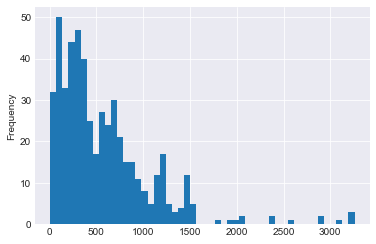

In [25]:

daily_aggregated.groupby('station_id').size().sort_values(ascending=False)
daily_aggregated.groupby('station_id').size().plot(kind='hist', bins=50)
# plt.show()

plt.savefig('station_id_hist.png', dpi=400)


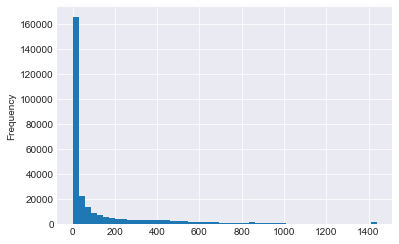

In [26]:
daily_aggregated['daily_blackout_time'].plot(kind='hist', bins=50)

plt.savefig('daily_blackout_time_hist.png', dpi=400)